In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Computer vision libraries in PyTorch

* `torchvision.datasets` - get datasets and data loading functions for computer vision
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` - base dataset class for PyTorch
* `torch.utils.data.DataLoader` - creates a Python iterable over a dataset

In [20]:
# Import PyTorch libraries
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

In [21]:
# Setup training data
train_data = datasets.FashionMNIST(
    root='data', 
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(), # function to transform the features
    target_transform=None # function to transform the labels
    )

test_data = datasets.FashionMNIST(
    root='data', 
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(), # function to transform the features
    target_transform=None # function to transform the labels
    )

In [22]:
len(train_data), len(test_data)

(60000, 10000)

In [23]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [24]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [25]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [26]:
image.shape # Colour, Height, Width

torch.Size([1, 28, 28])

### Visualizing our data

(-0.5, 27.5, 27.5, -0.5)

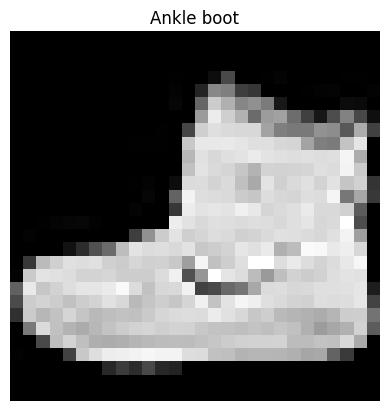

In [27]:
plt.imshow(image.squeeze(), cmap = 'gray')
plt.title(class_names[label])
plt.axis(False)

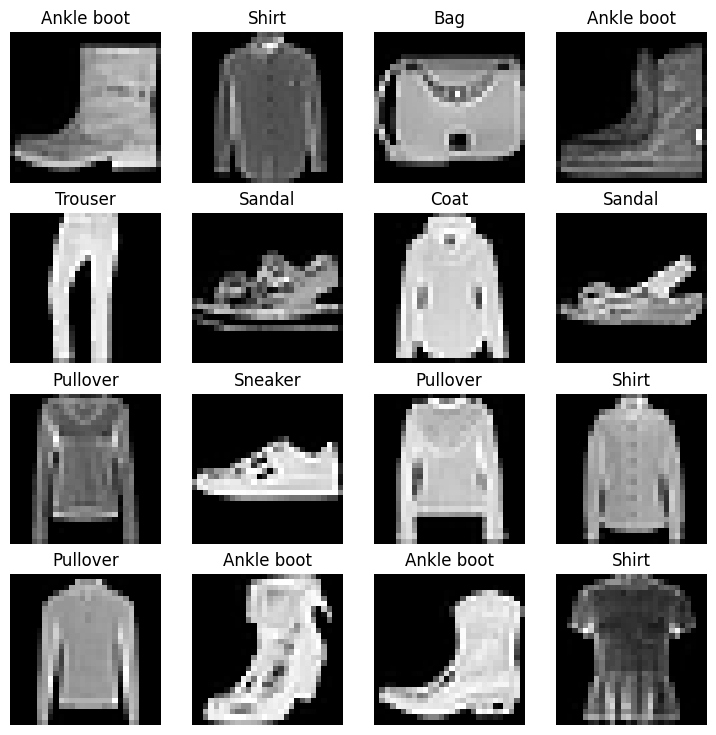

In [28]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0,len(train_data), size = [1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap = 'gray')
    plt.title(class_names[label])
    plt.axis(False)
    

### Prepare DataLoader

Right now, data is in the form of PyTorch Datasets.

DataLoader turns our dataset into a Python iterable. More specifically, we want to turn our data into batches (or mini-batches) because:

1. It is more computationally efficient, as in, your computing hardware may not be able to look (stor in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32).
1. It gives our neural network more chances to update its gradients per epoch.

In [29]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True )

test_dataloader = DataLoader(dataset = test_data,
                             batch_size= BATCH_SIZE,
                             shuffle = False)


In [30]:
# What's in side the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 8, label size: torch.Size([])


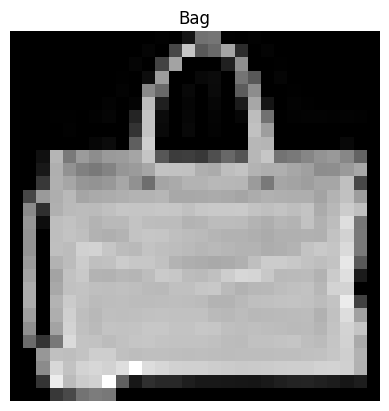

In [31]:
# Show a sample
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size = [1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap = 'gray')
plt.title(class_names[label])
plt.axis(False)
print(f'Image size: {image.shape}')
print(f'Label: {label}, label size: {label.shape}')

### Build a baseline model

When starting to build a series of machine learning experiments, it's best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/ experiments.ExceptionGroup

Start simply and add complexity when necessary.

In [32]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a simgle sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x)

print(f'Shape before flattening: {x.shape} -> [colour_channels, height, width]')
print(f'Shape after flattening: {output.shape} -> [colour_channels, height*width]')

Shape before flattening: torch.Size([1, 28, 28]) -> [colour_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [colour_channels, height*width]


In [33]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [34]:
torch.manual_seed(42)

# Setup model
model_0 = FashionMNISTModelV0(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
)
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

### Setup loss, optimizer and evaluation metrics

* Loss function - since we're working with multi-class data, our loss fuction will be `nn.CrossEntropyLoss()`.
* Optimizer - our optimizer `torch.optim.SGD()`.
* Evaluation metric - since we're working on a class fication problem, let's use accuracy as our evaluation metric.

In [35]:
# Import a function called `plot_decision_boundary()`
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
    print('helper_functions.py already exists. Skipping download.')
else:
    print("Download helper_functions.py")
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open("helper_functions.py", 'wb') as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn

helper_functions.py already exists. Skipping download.


In [36]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### Creating a function to time our experiments

Machine learning is very experimental.

Two of the main things that you'll often want to track are:
1. Model's performance (loss and accuracy values etc)
1. How fast it runs

In [37]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [38]:
start_time = timer()
# some code ...
end_time = timer()
print_train_time(start_time, end_time, device = 'cpu')

Train time on cpu: 0.000 seconds


1.7200130969285965e-05

### Creating a training loop and training a model on batches of data

1. Loop through epochs.
1. Loop through training batches, perform training steps, calculate the train loss *per batch*.
1. Loop through the testing batches, perform testing steps, calculate the test loss *per batch*.
1. Print out whats happening.
1. Time it all.

In [40]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        print(batch, X.shape, y.shape)
        model_0.train() 
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
0 torch.Size([32, 1, 28, 28]) torch.Size([32])
Looked at 0/60000 samples
1 torch.Size([32, 1, 28, 28]) torch.Size([32])
2 torch.Size([32, 1, 28, 28]) torch.Size([32])
3 torch.Size([32, 1, 28, 28]) torch.Size([32])
4 torch.Size([32, 1, 28, 28]) torch.Size([32])
5 torch.Size([32, 1, 28, 28]) torch.Size([32])
6 torch.Size([32, 1, 28, 28]) torch.Size([32])
7 torch.Size([32, 1, 28, 28]) torch.Size([32])
8 torch.Size([32, 1, 28, 28]) torch.Size([32])
9 torch.Size([32, 1, 28, 28]) torch.Size([32])
10 torch.Size([32, 1, 28, 28]) torch.Size([32])
11 torch.Size([32, 1, 28, 28]) torch.Size([32])
12 torch.Size([32, 1, 28, 28]) torch.Size([32])
13 torch.Size([32, 1, 28, 28]) torch.Size([32])
14 torch.Size([32, 1, 28, 28]) torch.Size([32])
15 torch.Size([32, 1, 28, 28]) torch.Size([32])
16 torch.Size([32, 1, 28, 28]) torch.Size([32])
17 torch.Size([32, 1, 28, 28]) torch.Size([32])
18 torch.Size([32, 1, 28, 28]) torch.Size([32])
19 torch.Size([32, 1, 28, 28]) torch.Size([32])
20 torc

 33%|███▎      | 1/3 [00:06<00:13,  6.62s/it]


Train loss: 0.46645 | Test loss: 0.47734, Test acc: 83.03%

Epoch: 1
-------
0 torch.Size([32, 1, 28, 28]) torch.Size([32])
Looked at 0/60000 samples
1 torch.Size([32, 1, 28, 28]) torch.Size([32])
2 torch.Size([32, 1, 28, 28]) torch.Size([32])
3 torch.Size([32, 1, 28, 28]) torch.Size([32])
4 torch.Size([32, 1, 28, 28]) torch.Size([32])
5 torch.Size([32, 1, 28, 28]) torch.Size([32])
6 torch.Size([32, 1, 28, 28]) torch.Size([32])
7 torch.Size([32, 1, 28, 28]) torch.Size([32])
8 torch.Size([32, 1, 28, 28]) torch.Size([32])
9 torch.Size([32, 1, 28, 28]) torch.Size([32])
10 torch.Size([32, 1, 28, 28]) torch.Size([32])
11 torch.Size([32, 1, 28, 28]) torch.Size([32])
12 torch.Size([32, 1, 28, 28]) torch.Size([32])
13 torch.Size([32, 1, 28, 28]) torch.Size([32])
14 torch.Size([32, 1, 28, 28]) torch.Size([32])
15 torch.Size([32, 1, 28, 28]) torch.Size([32])
16 torch.Size([32, 1, 28, 28]) torch.Size([32])
17 torch.Size([32, 1, 28, 28]) torch.Size([32])
18 torch.Size([32, 1, 28, 28]) torch.Size(

 67%|██████▋   | 2/3 [00:13<00:06,  6.51s/it]


Train loss: 0.45035 | Test loss: 0.47075, Test acc: 83.62%

Epoch: 2
-------
0 torch.Size([32, 1, 28, 28]) torch.Size([32])
Looked at 0/60000 samples
1 torch.Size([32, 1, 28, 28]) torch.Size([32])
2 torch.Size([32, 1, 28, 28]) torch.Size([32])
3 torch.Size([32, 1, 28, 28]) torch.Size([32])
4 torch.Size([32, 1, 28, 28]) torch.Size([32])
5 torch.Size([32, 1, 28, 28]) torch.Size([32])
6 torch.Size([32, 1, 28, 28]) torch.Size([32])
7 torch.Size([32, 1, 28, 28]) torch.Size([32])
8 torch.Size([32, 1, 28, 28]) torch.Size([32])
9 torch.Size([32, 1, 28, 28]) torch.Size([32])
10 torch.Size([32, 1, 28, 28]) torch.Size([32])
11 torch.Size([32, 1, 28, 28]) torch.Size([32])
12 torch.Size([32, 1, 28, 28]) torch.Size([32])
13 torch.Size([32, 1, 28, 28]) torch.Size([32])
14 torch.Size([32, 1, 28, 28]) torch.Size([32])
15 torch.Size([32, 1, 28, 28]) torch.Size([32])
16 torch.Size([32, 1, 28, 28]) torch.Size([32])
17 torch.Size([32, 1, 28, 28]) torch.Size([32])
18 torch.Size([32, 1, 28, 28]) torch.Size(

100%|██████████| 3/3 [00:19<00:00,  6.54s/it]


Train loss: 0.44035 | Test loss: 0.47019, Test acc: 83.65%

Train time on cpu: 19.613 seconds


### Make predictions and get model_0 results


### Setup  device agnostic

In [22]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [23]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn): 
    """Returns a dictionary of the results of model predicting on data_loader"""

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true = y,
                               y_pred = y_pred.argmax(dim = 1))
            
        # Scale the loss and acc to find the average loss/ acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

model_0_results = eval_model(model_0.to(device), test_dataloader, loss_fn, accuracy_fn)


100%|██████████| 313/313 [00:05<00:00, 61.14it/s] 


### Build model with non-linearity 


In [24]:
# Create a model with non-linear and linear layers

class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

model_1 = FashionMNISTModelV1(input_shape=28*28, hidden_units=10, output_shape=len(class_names)).to(device)

In [25]:
# Specify loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

# Load in evaluator function
from helper_functions import accuracy_fn

Create a function for:
* Training loop - `train_step()`
* Testing loop - `test_step()`

In [26]:
# Create a function for training and testing

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               accuracy_fn,
               device: torch.device = device):
    
    ### Training
    train_loss, train_acc = 0, 0

    model.train()

    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 
        train_acc += accuracy_fn(y_true = y,
                                 y_pred = y_pred.argmax(dim=1)) # Go from logits to prediction labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f'Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%')


def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0 

    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(data_loader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


In [27]:
torch.manual_seed(42)
from timeit import default_timer as timer

train_time_start_on_gpu = timer()

# Set epochs
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n')
    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)
    
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device = device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0

Train loss: 1.11456 | Train accuracy: 58.46%


 33%|███▎      | 1/3 [00:14<00:28, 14.05s/it]

Test loss: 0.93336, Test acc: 64.23%

Epoch: 1

Train loss: 0.92061 | Train accuracy: 64.47%


 67%|██████▋   | 2/3 [00:29<00:14, 14.84s/it]

Test loss: 0.92247, Test acc: 64.46%

Epoch: 2

Train loss: 0.54459 | Train accuracy: 80.42%


100%|██████████| 3/3 [00:44<00:00, 14.80s/it]

Test loss: 0.44046, Test acc: 84.60%

Train time on cuda: 44.411 seconds


**Note:** Sometimes, depending on your data/hardware you might find that your model trains faster on CPU than GPU.

Why is this:

1. It could be that the overhead for copying data/ model to and from the GPU outweighs the compute benfits offered by the GPU.
1. The hardware you're using has a better CPU in terms compute capabilith than the GPU. 

In [28]:
model_0_results, total_train_time_model_0

({'model_name': 'FashionMNISTModelV0',
  'model_loss': 0.4766389727592468,
  'model_acc': 83.42651757188499},
 20.313995799981058)

In [29]:
model_1_results = eval_model(model_1, test_dataloader, loss_fn, accuracy_fn)
model_1_results, total_train_time_model_1

100%|██████████| 313/313 [00:00<00:00, 314.50it/s]


({'model_name': 'FashionMNISTModelV1',
  'model_loss': 0.48347973823547363,
  'model_acc': 83.23682108626198},
 44.41073050000705)

### Building a Convolutional Neural Network (CNN or ConvNet)

The CNN model we'll be using is know as TinyVGG from the [CNN explainer](https://poloclub.github.io/cnn-explainer/) website and compare it against our baseline model.

It follows the typical structure of a CNN:

`Input layer -> [Convolutional layer -> Activation layer -> Pooling layer] -> Output layer`

where the contenst of `[Convolutional layer -> Activation layer -> Pooling layer]` can be upscaled and repeated multiple times, depending on requirements.

In [30]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [31]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,hidden_units=10,output_shape=len(class_names)).to(device)

In [32]:
torch.manual_seed(42)

# Create a batch of images 
images = torch.randn(size = (32,3,64,64))
test_image = images[0]

test_image.shape

torch.Size([3, 64, 64])

In [33]:
torch.manual_seed(42)

# Create a convolutional layer with same dimensions as TinyVGG 
# (try changing any of the parameters and see what happens)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0) # also try using "valid" or "same" here 

# Pass the data through the convolutional layer
conv_layer(test_image) 

tensor([[[ 1.5396,  0.0516,  0.6454,  ..., -0.3673,  0.8711,  0.4256],
         [ 0.3662,  1.0114, -0.5997,  ...,  0.8983,  0.2809, -0.2741],
         [ 1.2664, -1.4054,  0.3727,  ..., -0.3409,  1.2191, -0.0463],
         ...,
         [-0.1541,  0.5132, -0.3624,  ..., -0.2360, -0.4609, -0.0035],
         [ 0.2981, -0.2432,  1.5012,  ..., -0.6289, -0.7283, -0.5767],
         [-0.0386, -0.0781, -0.0388,  ...,  0.2842,  0.4228, -0.1802]],

        [[-0.2840, -0.0319, -0.4455,  ..., -0.7956,  1.5599, -1.2449],
         [ 0.2753, -0.1262, -0.6541,  ..., -0.2211,  0.1999, -0.8856],
         [-0.5404, -1.5489,  0.0249,  ..., -0.5932, -1.0913, -0.3849],
         ...,
         [ 0.3870, -0.4064, -0.8236,  ...,  0.1734, -0.4330, -0.4951],
         [-0.1984, -0.6386,  1.0263,  ..., -0.9401, -0.0585, -0.7833],
         [-0.6306, -0.2052, -0.3694,  ..., -1.3248,  0.2456, -0.7134]],

        [[ 0.4414,  0.5100,  0.4846,  ..., -0.8484,  0.2638,  1.1258],
         [ 0.8117,  0.3191, -0.0157,  ...,  1

In [34]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [35]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n--------')
    train_step(data_loader=train_dataloader,
               model=model_2,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device
               )
    
    test_step(data_loader=test_dataloader,
              model=model_2,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device
              )
    
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 0.59425 | Train accuracy: 78.31%


 33%|███▎      | 1/3 [00:12<00:24, 12.42s/it]

Test loss: 0.39441, Test acc: 86.30%

Epoch: 1
--------
Train loss: 0.36090 | Train accuracy: 86.91%


 67%|██████▋   | 2/3 [00:23<00:11, 11.57s/it]

Test loss: 0.34898, Test acc: 87.63%

Epoch: 2
--------
Train loss: 0.32631 | Train accuracy: 88.16%


100%|██████████| 3/3 [00:34<00:00, 11.43s/it]

Test loss: 0.33425, Test acc: 88.05%

Train time on cuda: 34.305 seconds


In [36]:
# Record model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

model_2_results

100%|██████████| 313/313 [00:01<00:00, 245.18it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.33424630761146545,
 'model_acc': 88.0491214057508}

### Compare model results and training time

We've trained 3 different models.

1. `model_0` - our baseline model with only two `nn.Linear()` layers.
1. `model_1` - the same setup as our baseline model except that `nn.ReLU()` layers in between the `nn.Linear()` layers.
1. `model_2` - our first CNN model that mimics the TinyVGG architecture on the CNN Explainer website.

We've built multiple models and performed multiple training experiments to see which performs best. 

We will now compile the model results dictionaries into a DataFrame and figure out.

In [37]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.483480,83.236821
2,FashionMNISTModelV2,0.334246,88.049121


In [38]:
# Add training times to results comparison
compare_results['training_time'] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]

compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,20.313996
1,FashionMNISTModelV1,0.483480,83.236821,44.410731
2,FashionMNISTModelV2,0.334246,88.049121,34.304916


Text(0, 0.5, 'Model')

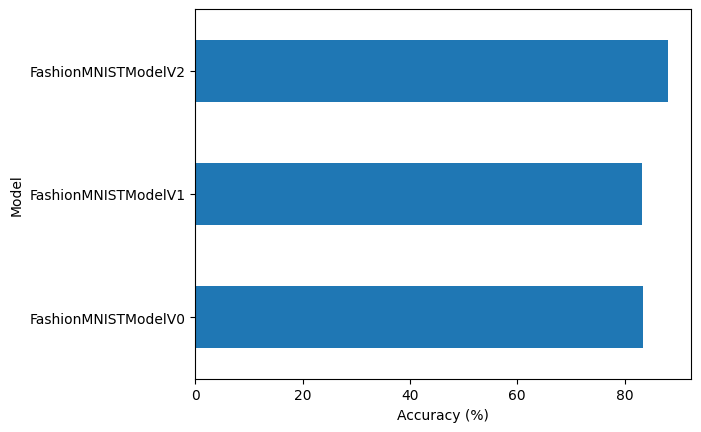

In [39]:
# Visualize our model results
compare_results.set_index('model_name')['model_acc'].plot(kind='barh')
plt.xlabel('Accuracy (%)')
plt.ylabel('Model')

### Make and evaluate random predictions with best model

Create a function `make_perdictions()` where we can pass the model and some data for it to predict on.

In [40]:
def make_predictions(model:torch.nn.Module, data:list, device:torch.device = device):
    pred_probs=[]
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Do a forward pass
            pred_logit = model(sample)

            # Get prediciton probability
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)


In [41]:
import random

random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k = 9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [42]:
# Make predictions on test samples with model 2
pred_probs = make_predictions(model=model_2,data=test_samples)

pred_probs[:2]

tensor([[5.0344e-07, 1.8015e-08, 4.1909e-08, 1.5252e-07, 2.8151e-08, 9.9976e-01,
         1.8994e-07, 3.3142e-05, 2.7625e-05, 1.8041e-04],
        [2.1179e-02, 8.6328e-01, 1.5117e-03, 1.0337e-01, 5.3682e-03, 1.1621e-04,
         4.8785e-03, 1.0433e-04, 7.2218e-05, 1.1435e-04]])

In [43]:
# Turn probabilities into prediction labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes, test_labels

(tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]), [5, 1, 7, 4, 3, 0, 4, 7, 1])

### Making a confusion matrix for further prediciton evaluations

To make a confusion matrix, we need to go through 3 steps:

1. Make predictions with our trained model, model_2 (a confusion matrix compares predicitons to true lables).
1. Make a confusion matrix using `torchmetrics.ConfusionMatrix()`.
1. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`.

In [44]:
from tqdm.auto import tqdm

# 1. Make predictions
y_preds=[]
model_2.eval()
with torch.inference_mode():
    for X,y in tqdm(test_dataloader, desc='Making predictions'):
        # Send the data to the correct device
        X,y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model_2(X)
        # Turn the predictions from logits -> probabilities -> label
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        # Put prediciotns on CPU for evaluation
        y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor= torch.cat(y_preds)


Making predictions: 100%|██████████| 313/313 [00:01<00:00, 199.80it/s]


In [45]:
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split('.')[1]) >= 19

0.22.0


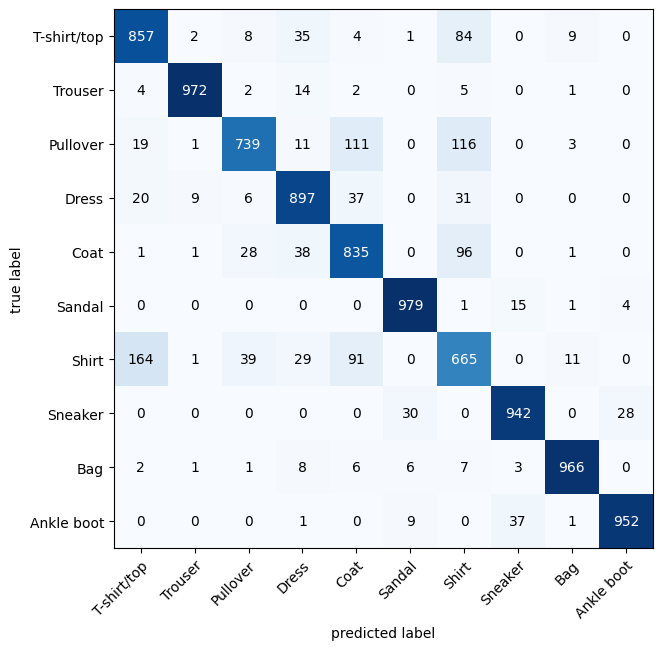

In [46]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat= ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor= confmat(preds=y_pred_tensor,
                        target=test_data.targets)

# 3. Plot the confusion matrix
fig,ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10,7)
)

### Save and load best performing model

Functions to use:
1. `torch.save`
1. `torch.load`
1. `torch.nn.Module.load_state_dict()`

In [49]:
from pathlib import Path

# Create a 'model' directory if it doesn't exist
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = 'pytorch_computer_vision_model_2.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the state dict of the model
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models\pytorch_computer_vision_model_2.pth


In [51]:
# Now that we have saved it we can load it back using a new instance of FashionMNISTModelV2()
loaded_model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=10)

# Load in state_dict from the saved model
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)


In [53]:
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model = loaded_model_2,
    data_loader = test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

100%|██████████| 313/313 [00:01<00:00, 199.02it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.33424630761146545,
 'model_acc': 88.0491214057508}

In [54]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.33424630761146545,
 'model_acc': 88.0491214057508}

In [55]:
# We can check whether the results are close by using torch.isclose()

torch.isclose(
    torch.tensor(model_2_results['model_loss']),
    torch.tensor(loaded_model_2_results['model_loss']),
    rtol=0.0001,
    atol=1e-8
)

tensor(True)